Mounting to Google Drive and making the necessary imports:

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
%%capture 
!pip install autolens

In [2]:
import autolens as al
import autolens.plot as aplt

First I create a 2d grid:

In [4]:
grid = al.Grid2D.uniform(shape_native=(150,150), pixel_scales=0.05, sub_size=2)

I then create the a source galaxy and a lens gfalaxy based on the paper [Dark Disk Substructure and Superfluid Dark Matter](https://arxiv.org/pdf/1901.03694.pdf).

First, I'll create the soure galaxy:

In [17]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllipticalSersic(
        centre=(0.0, 0.0),
        elliptical_comps=(0.2, 0.3),
        intensity=1.0,
        effective_radius=2.0,
        sersic_index=4.0,
    ),
    disk=al.lp.EllipticalSersic(
        centre=(0.0, 0.0),
        elliptical_comps=(0.2, 0.3),
        intensity=1.0,
        effective_radius=1.0,
        sersic_index=1.0,
    ),
)

And then plot it!

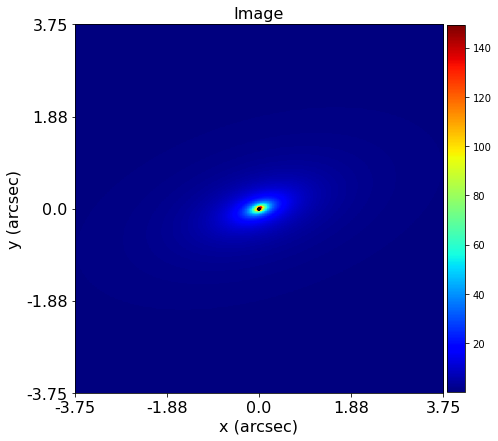

In [18]:
tracer_source = al.Tracer.from_galaxies(galaxies=[source_galaxy])
tracer_plotter = aplt.TracerPlotter(tracer=tracer_source, grid=grid)
tracer_plotter.figures(image=True)

We can then create the galaxy that'll work as a lens:

In [26]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), einstein_radius=1.2, elliptical_comps=(0.2, 0.3)
    ),
)

Which enables us to plot it:

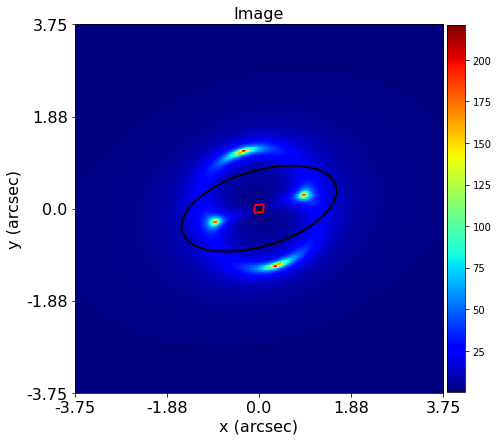

In [27]:
tracer = al.Tracer.from_galaxies(galaxies=[source_galaxy, lens_galaxy])
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures(image=True)

In order to achieve more realistic simulations (which is especially interesting for Machine Learning) we can apply a filter that simulates how the lens would be observed from a telescope:

In [55]:
psf = al.Kernel2D.from_gaussian(
    shape_native=(5, 5), sigma=0.7, pixel_scales=grid.pixel_scales
)

simulator = al.SimulatorImaging(
    exposure_time=100.0,
    background_sky_level=0.6,
    psf=psf,
    add_poisson_noise=True,
)


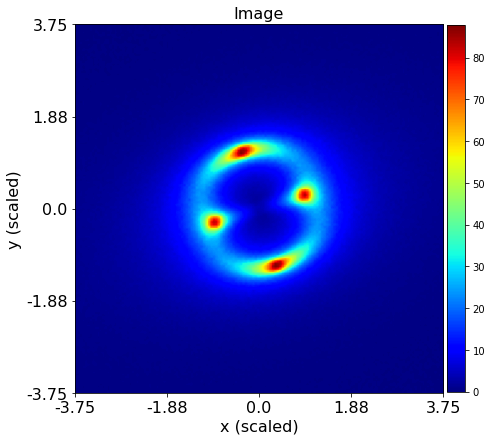

In [56]:
imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)
imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.figures(image=True)

Something that would make these simulations way more realistic would be to apply these simulations in real images, thus having background galaxies and stars, as well as a more realistic sky level. This would simulate these lenses in real world situations. It is, though, way more expensive and complex to create simulations such as these.

The following cells will function as an example of just that! The .fits image that is used is from a Low Surface Brightness Galaxy, and is one of the images that I use for training a CNN on my other project, Deepfuse. The image has three bands: g, r and z.

First we'll open the image by itself. I'm going to plot only the g-band of the image:

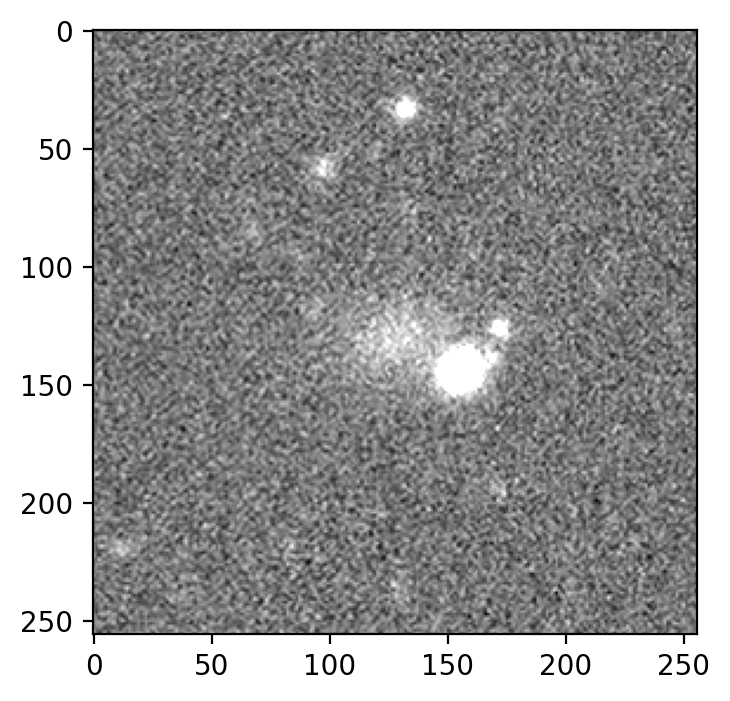

In [57]:
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import numpy as np

f = os.path.join('/content/drive/MyDrive/ml4sci/superfluid_dark_matter', '8.fits')
hdul = fits.open(f)
img = hdul[0].data

plt.figure(figsize=(4,4), dpi=200)
avg = np.mean(img[0])
plt.imshow(img[0], vmin=avg-0.01, vmax=avg+0.01, cmap='binary_r')

We could then impose our simulated lens into this image by calling:

In [59]:
imaging = al.Imaging.from_fits(
    image_path = f,
    pixel_scales = 0.05,
    psf_path = psf,
    noise_map_path = noise_map,
)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.figures(image=True)

Unfortunetely I don't have neither a `psf` file nor a `noise_map` file of this image :(